In [ ]:
import h5py
import zipfile
import imageio
import os


import torch
import torch.nn as nn
from torch.utils.data import Dataset

import h5py
import pandas, numpy, random
import matplotlib.pyplot as plt

데이터 살펴보기, 데이터 불러오기

In [ ]:
%%time

# HDF5 패키지가 위치하는 경로
hdf5_file = "/content/drive/MyDrive//celeba_aligned_small.h5py"

# 몇개 이미지를 HDF5로 패키징할지 설정
total_images = 20000

with h5py.File(hdf5_file, 'w') as hf:

    count = 0

    with zipfile.ZipFile("/content/drive/MyDrive/GAN/source1.zip", 'r') as zf:
      for i in zf.namelist():
        if (i[-4:] == '.jpg'):
          # 이미지 추출
          ofile = zf.extract(i)
          img = imageio.imread(ofile)
          os.remove(ofile)

          # 이미지 데이터를 HDF5 파일에 새로운 이름으로 추가
          hf.create_dataset('img_align_celeba/'+str(count)+'.jpg', data=img, compression="gzip", compression_opts=9)

          count = count + 1
          if (count%1000 == 0):
            print("images done .. ", count)
            pass

          # total_images 수만큼만 추가
          if (count == total_images):
            break
          pass

        pass
      pass

<timed exec>:16: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.


images done ..  1000
images done ..  2000
images done ..  3000
images done ..  4000
images done ..  5000
images done ..  6000
images done ..  7000
images done ..  8000
images done ..  9000
images done ..  10000
images done ..  11000
images done ..  12000
images done ..  13000
images done ..  14000
images done ..  15000
images done ..  16000
images done ..  17000
images done ..  18000
images done ..  19000
images done ..  20000
CPU times: user 3min 33s, sys: 16.3 s, total: 3min 49s
Wall time: 4min 56s


In [ ]:
with h5py.File("/content/drive/MyDrive//celeba_aligned_small.h5py", 'r') as file_object:

  for group in file_object:
    print(group)
    pass

img_align_celeba


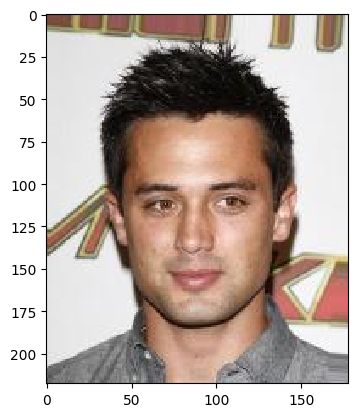

In [ ]:
with h5py.File("/content/drive/MyDrive//celeba_aligned_small.h5py", 'r') as file_object:
  dataset = file_object['img_align_celeba']
  image = numpy.array(dataset['6.jpg'])
  plt.imshow(image, interpolation='none')
  pass


In [ ]:
# image 행렬의 형태 확인

image.shape

(218, 178, 3)

In [ ]:
if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print("using cuda:", torch.cuda.get_device_name(0))
  pass

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using cuda: Tesla T4


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


device(type='cuda')

데이터셋 클래스

In [ ]:
# 데이터셋 클래스
class CelebADataset(Dataset):

    def __init__(self, file):
        self.file_object = h5py.File(file, 'r')
        self.dataset = self.file_object['img_align_celeba']
        pass

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if (index >= len(self.dataset)):
          raise IndexError()
        img = numpy.array(self.dataset[str(index)+'.jpg'])
        return torch.cuda.FloatTensor(img) / 255.0

    def plot_image(self, index):
        plt.imshow(numpy.array(self.dataset[str(index)+'.jpg']), interpolation='nearest')
        pass

    pass


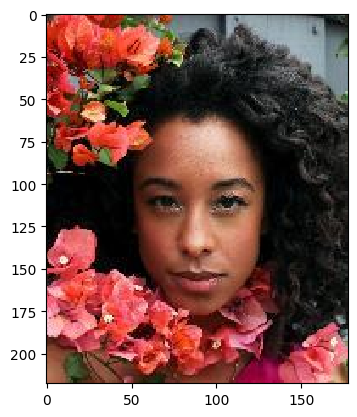

In [ ]:
celeba_dataset = CelebADataset("/content/drive/MyDrive//celeba_aligned_small.h5py")
celeba_dataset.plot_image(43)

In [ ]:
def generate_random_image(size): # 0과 1 사이
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size): # 평균이 0 이고 표준편차가 1
    random_data = torch.randn(size)
    return random_data

In [ ]:
class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape,

    def forward(self, x):
        return x.view(*self.shape)

판별기 함수 정의 , 판별기 함수 테스트 하기

In [ ]:
class Discriminator(nn.Module):

    def __init__(self):
        super().__init__()

       # 신경망 레이어 정의
        self.model = nn.Sequential(
            View(218*178*3),

            nn.Linear(3*218*178, 100),
            nn.LeakyReLU(),

            nn.LayerNorm(100),

            nn.Linear(100, 1),
            nn.Sigmoid()
        )

        # 손실 함수 생성
        self.loss_function = nn.BCELoss()

        # 옵티마이저 생성
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []

        pass


    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)


    def train(self, inputs, targets):
        # 신경망 출력 계산
        outputs = self.forward(inputs)

        # 손실 계산
        loss = self.loss_function(outputs, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

In [ ]:
D = Discriminator()
D.to(device)

for image_data_tensor in celeba_dataset:
    # 실제 데이터
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))
    # 생성된 데이터
    D.train(generate_random_image((218,178,3)), torch.cuda.FloatTensor([0.0]))
    pass

<ipython-input-5-a7d6793da831>:16: UserWarning: The torch.cuda.*DtypeTensor constructors are no longer recommended. It's best to use methods such as torch.tensor(data, dtype=*, device='cuda') to create tensors. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:83.)
  return torch.cuda.FloatTensor(img) / 255.0


counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000


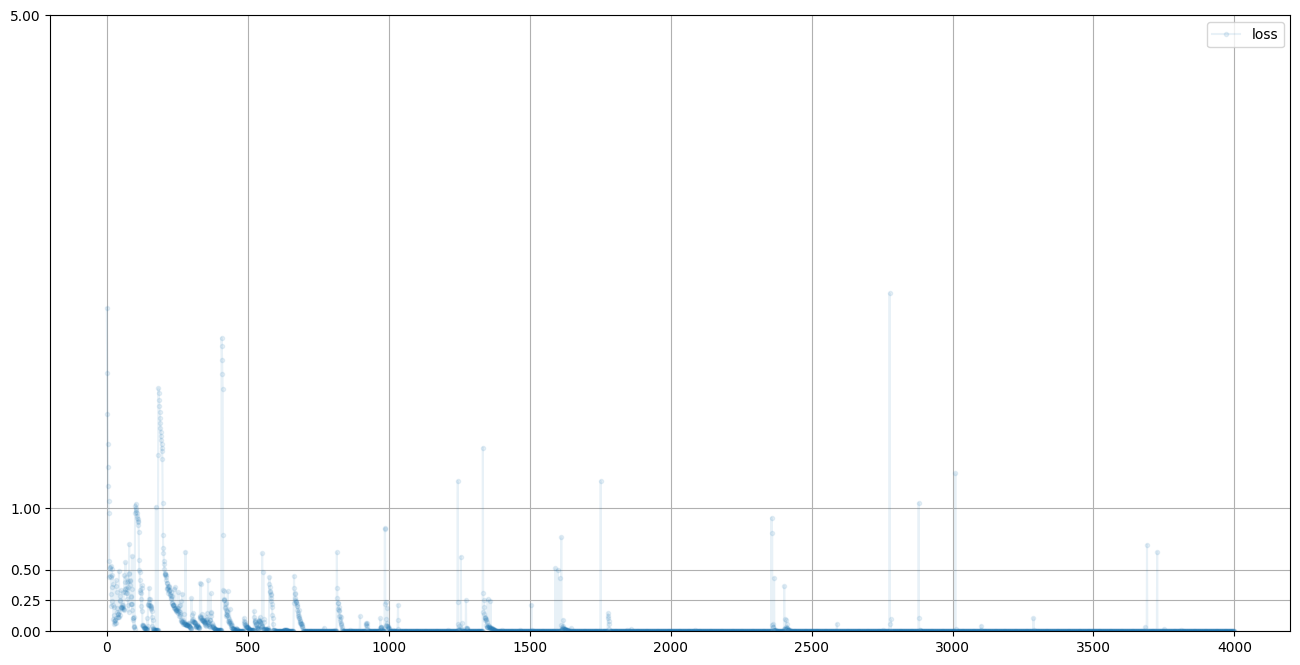

In [ ]:
D.plot_progress()

In [ ]:
for i in range(4):
  image_data_tensor = celeba_dataset[random.randint(0,20000)]
  print( D.forward( image_data_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image((218,178,3))).item() )
  pass

0.9991921782493591
0.9999344348907471
0.9997994303703308
0.999941349029541
2.969655361084733e-05
4.076425830135122e-05
2.9979504688526504e-05
2.997687624883838e-05


생성기 함수 정의하기, 생성기 함수 테스트 하기

In [ ]:
class Generator(nn.Module):

    def __init__(self):
        super().__init__()

        # 신경망 레이어 정의
        self.model = nn.Sequential(
            nn.Linear(100, 3*10*10),
            nn.LeakyReLU(),

            nn.LayerNorm(3*10*10),

            nn.Linear(3*10*10, 3*218*178),

            nn.Sigmoid(),
            View((218,178,3))
        )

        # 옵티마이저 생성
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)

        # 진행 측정을 위한 변수 초기화
        self.counter = 0;
        self.progress = []

        pass


    def forward(self, inputs):
        # 모델 실행
        return self.model(inputs)


    def train(self, D, inputs, targets):
        # 신경망 출력 계산
        g_output = self.forward(inputs)

        # 판별기에 값 전달
        d_output = D.forward(g_output)

        # 오차 계산
        loss = D.loss_function(d_output, targets)

        # 매 10회마다 에러를 누적하고 카운터를 증가
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # 기울기를 초기화 하고 역전파 후 가중치 갱신
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

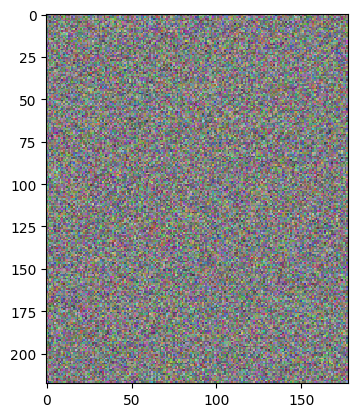

In [ ]:
G = Generator()
G.to(device)

output = G.forward(generate_random_seed(100))

img = output.detach().cpu().numpy()

plt.imshow(img, interpolation='none', cmap='Blues')

GAN 훈련하기

In [ ]:
D = Discriminator()
D.to(device)
G = Generator()
G.to(device)

epochs = 1

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)

  # 판별기와 생성기 훈련

  for image_data_tensor in celeba_dataset:
    # 참일 경우 판별기 훈련
    D.train(image_data_tensor, torch.cuda.FloatTensor([1.0]))

    # 거짓일 경우 판별기 훈련
    # G의 기울기가 계산되지 않도록 detach() 함수를 이용
    D.train(G.forward(generate_random_seed(100)).detach(), torch.cuda.FloatTensor([0.0]))

    # 생성기 훈련
    G.train(D, generate_random_seed(100), torch.cuda.FloatTensor([1.0]))

    pass

  pass

epoch =  1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000
counter =  11000
counter =  12000
counter =  13000
counter =  14000
counter =  15000
counter =  16000
counter =  17000
counter =  18000
counter =  19000
counter =  20000
counter =  21000
counter =  22000
counter =  23000
counter =  24000
counter =  25000
counter =  26000
counter =  27000
counter =  28000
counter =  29000
counter =  30000
counter =  31000
counter =  32000
counter =  33000
counter =  34000
counter =  35000
counter =  36000
counter =  37000
counter =  38000
counter =  39000
counter =  40000


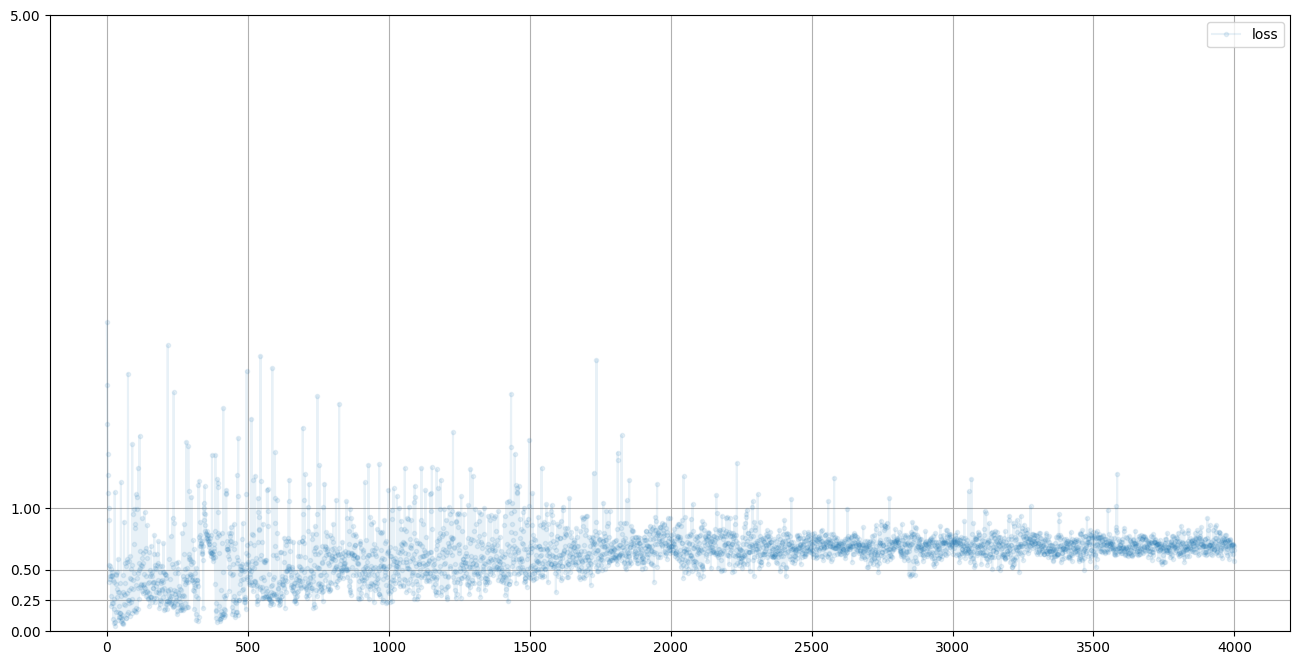

In [ ]:
D.plot_progress()

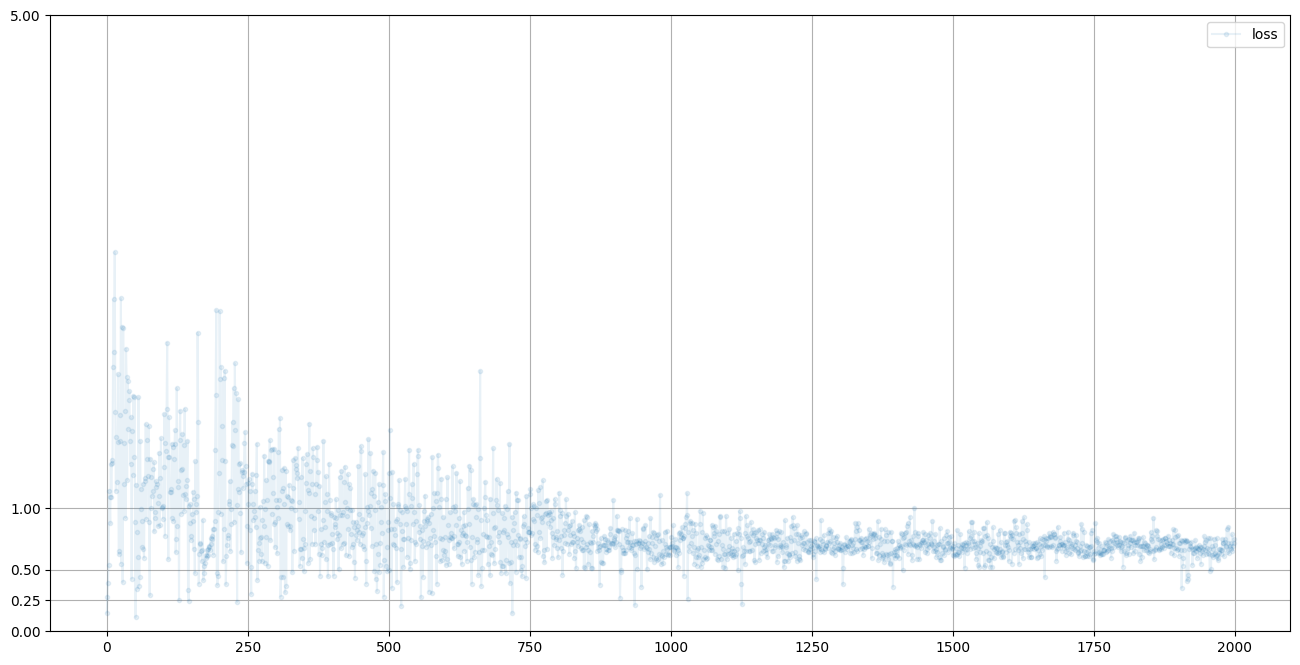

In [ ]:
G.plot_progress()

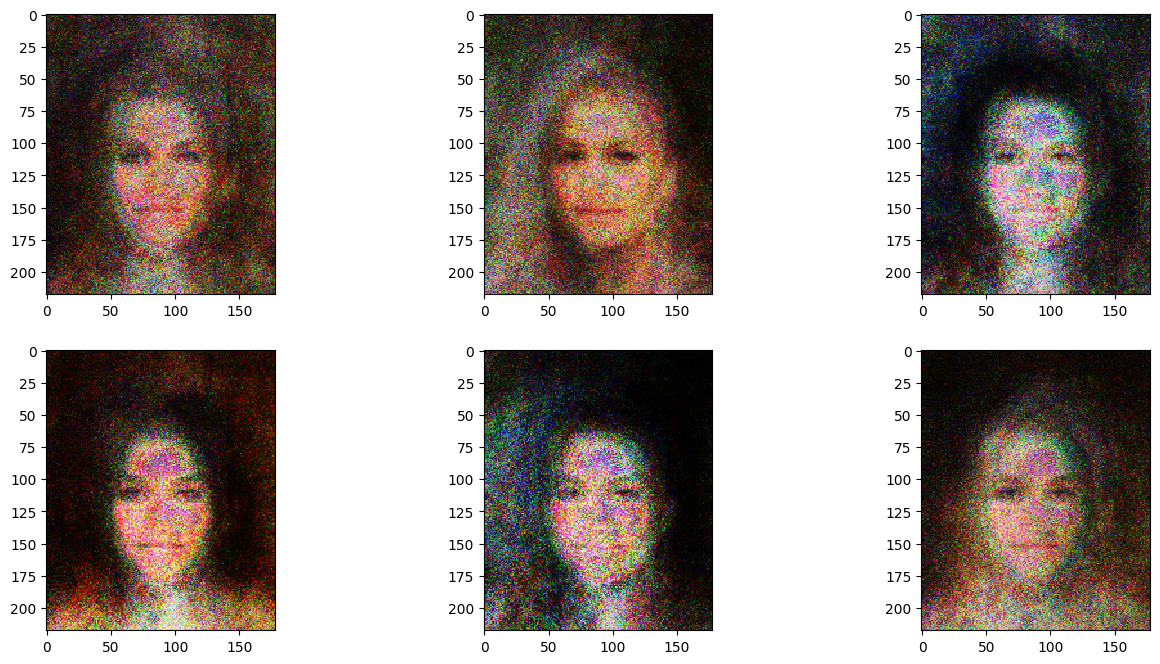

In [ ]:
f, axarr = plt.subplots(2,3, figsize=(16,8))
for i in range(2):
    for j in range(3):
        output = G.forward(generate_random_seed(100))
        img = output.detach().cpu().numpy()
        axarr[i,j].imshow(img, interpolation='none', cmap='Blues')
        pass
    pass